# Part 2: Impact Metrics

In this notebook we are going to 

* Load the researchers data previously extracted
* Enrich it by building a dataset focusing on their impact in terms of no of papers, citations etc.. 
* Visualize the results with plotly to have a quick overview of the results 

## Prerequisites: Installing the Dimensions Library and Logging in

In [1]:

# @markdown # Get the API library and login
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly tqdm -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import os
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm as progress

#
# charts libs
# import plotly_express as px
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#
# create output data folder
if not(os.path.exists("data")):
    os.mkdir("data")

DimCli v0.6.7 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


## Measuring the Impact of Researchers within a Journal

Goal: from the list of authors and publications we previously extracted, we want to create a new dataset focused on **researchers** with the following information:
* number of papers
* citations median 
* altmetric median 
* last publication year 

This data will allow to determine the 'impact' of a researcher within the journal.

### Load the publications and authors data previously saved

In [2]:
dfpubs = pd.read_csv("data/1.pubs_metadata_with_metrics.csv")
authors = pd.read_csv("data/1.publications_authors.csv")

In [3]:
# replace empty values with 0 so to allow bulk calculations
dfpubs = dfpubs.fillna(0)
authors = authors.fillna(0)

### Isolate the Researchers data (= authors with an ID)

In [4]:
researchers = authors.query("researcher_id!=0")
print("Researchers total:",  len(researchers))
researchers.head(10)

Researchers total: 32815


,first_name,last_name,initials,corresponding,orcid,current_organization_id,researcher_id,affiliations,is_bogus,pub_id
38,Gai,Huang,0.0,0,['0000-0003-0426-9691'],grid.11135.37,ur.0776534717.61,"[{'id': 'grid.49470.3e', 'name': 'Wuhan Univer...",0,pub.1126635334
39,Zhiguo,Wu,0.0,0,0,grid.49470.3e,ur.07420262026.60,"[{'id': 'grid.49470.3e', 'name': 'Wuhan Univer...",0,pub.1126635334
40,Richard G.,Percy,0.0,0,0,grid.463419.d,ur.01264556433.64,"[{'id': 'grid.463419.d', 'name': 'Agricultural...",0,pub.1126635334
41,Mingzhou,Bai,0.0,0,0,grid.21155.32,ur.013321161051.08,"[{'id': 'grid.21155.32', 'name': 'Beijing Geno...",0,pub.1126635334
43,James E.,Frelichowski,0.0,0,0,grid.463419.d,ur.0731473111.53,"[{'id': 'grid.463419.d', 'name': 'Agricultural...",0,pub.1126635334
44,Jiang,Hu,0.0,0,0,grid.459813.2,ur.013234461415.69,"[{'id': 'grid.459813.2', 'name': 'Nextomics Bi...",0,pub.1126635334
45,Kun,Wang,0.0,0,['0000-0001-5910-1568'],grid.49470.3e,ur.0730421517.29,"[{'id': 'grid.49470.3e', 'name': 'Wuhan Univer...",0,pub.1126635334
46,John Z.,Yu,0.0,True,0,grid.463419.d,ur.0620363615.42,"[{'id': 'grid.463419.d', 'name': 'Agricultural...",0,pub.1126635334
47,Yuxian,Zhu,0.0,True,['0000-0003-2371-5933'],grid.49470.3e,ur.01111252774.94,"[{'id': 'grid.49470.3e', 'name': 'Wuhan Univer...",0,pub.1126635334
48,Yoav,Voichek,0.0,0,0,grid.13992.30,ur.0767407745.78,"[{'id': 'grid.419495.4', 'name': 'Max Planck I...",0,pub.1126635876


### Enrich the data with Impact Statistics

First, let's pivot on the researcher ID field to eliminate duplicates and count them 

In [5]:
researchers_impact = researchers[['researcher_id', 'pub_id']].groupby('researcher_id', as_index=False).count().sort_values(by=['pub_id'], ascending=False).reset_index(drop=True)
researchers_impact.rename(columns={"pub_id": "pubs"}, inplace=True)
researchers_impact.head(10)

,researcher_id,pubs
0,ur.0723426172.10,62
1,ur.01277776417.51,45
2,ur.01247426430.47,33
3,ur.01313145634.66,32
4,ur.01317433110.75,31
5,ur.0641525362.39,31
6,ur.01264737414.70,30
7,ur.014377465057.81,28
8,ur.0616003437.07,27
9,ur.01220453202.22,27


Second, for each researcher ID we can query all of his/her publications so to calculate the following metrics: 

* citations median 
* altmetric median 
* last publication year 

Also, we add a new field with the Dimensions URL of the researcher, as it can be handy later on to open up its profile page online.


In [6]:

def get_name_surname(researcher_id):
    """
    eg
    >>> get_name_surname("ur.0723426172.10")
    'Kari Stefansson'
    """
    q = "researcher_id=='%s'" % researcher_id
    x = researchers.query(q)['first_name'].value_counts().idxmax()
    y = researchers.query(q)['last_name'].value_counts().idxmax()
    return f"{x} {y}"


# def dimensions_url(researcher_id):
#     return f"https://app.dimensions.ai/discover/publication?and_facet_researcher={researcher_id}"

fullnames, citations, altmetric, last_year, urls = [], [], [], [], []

for i, row in progress(researchers_impact.iterrows(), total=researchers_impact.shape[0]):
    q = "researcher_id=='%s'" % row['researcher_id']
    pub_ids = list(researchers.query(q)['pub_id'])
    fullnames.append(get_name_surname(row['researcher_id']))
    citations.append(dfpubs[dfpubs['id'].isin(pub_ids)]['times_cited'].mean())
    altmetric.append(dfpubs[dfpubs['id'].isin(pub_ids)]['altmetric'].mean())
    last_year.append(dfpubs[dfpubs['id'].isin(pub_ids)]['year'].max())
    urls.append(dimensions_url(row['researcher_id']))

researchers_impact['full_name'] = fullnames
researchers_impact['citations_mean'] = citations
researchers_impact['altmetric_mean'] = altmetric
researchers_impact['last_pub_year'] = last_year
researchers_impact['url'] = urls
# finally..
print("Researchers total:",  len(researchers_impact))
researchers_impact.head(10)


Researchers total: 18341


,researcher_id,pubs,full_name,citations_mean,altmetric_mean,last_pub_year,url
0,ur.0723426172.10,62,Kari Stefansson,103.274194,229.225806,2020,https://app.dimensions.ai/discover/publication...
1,ur.01277776417.51,45,Unnur Thorsteinsdottir,78.577778,159.666667,2019,https://app.dimensions.ai/discover/publication...
2,ur.01247426430.47,33,Gudmar Thorleifsson,77.878788,170.515152,2019,https://app.dimensions.ai/discover/publication...
3,ur.01313145634.66,32,Andres Metspalu,164.125000,362.875000,2019,https://app.dimensions.ai/discover/publication...
4,ur.01317433110.75,31,Caroline Hayward,136.322581,302.000000,2019,https://app.dimensions.ai/discover/publication...
5,ur.0641525362.39,31,Gonçalo R Abecasis,121.870968,144.838710,2019,https://app.dimensions.ai/discover/publication...
6,ur.01264737414.70,30,Tõnu Esko,148.033333,346.200000,2020,https://app.dimensions.ai/discover/publication...
7,ur.014377465057.81,28,Benjamin M. Neale,237.250000,177.964286,2020,https://app.dimensions.ai/discover/publication...
8,ur.0616003437.07,27,Claudia Langenberg,92.259259,263.444444,2019,https://app.dimensions.ai/discover/publication...
9,ur.01220453202.22,27,Eleftheria Zeggini,71.222222,208.185185,2019,https://app.dimensions.ai/discover/publication...


Save the data

In [10]:
researchers_impact.to_csv("data/2.researchers_impact_metrics.csv", index=False)

In [11]:
if COLAB_ENV:
  files.download("data/2.researchers_impact_metrics.csv")

## Couple of Dataviz

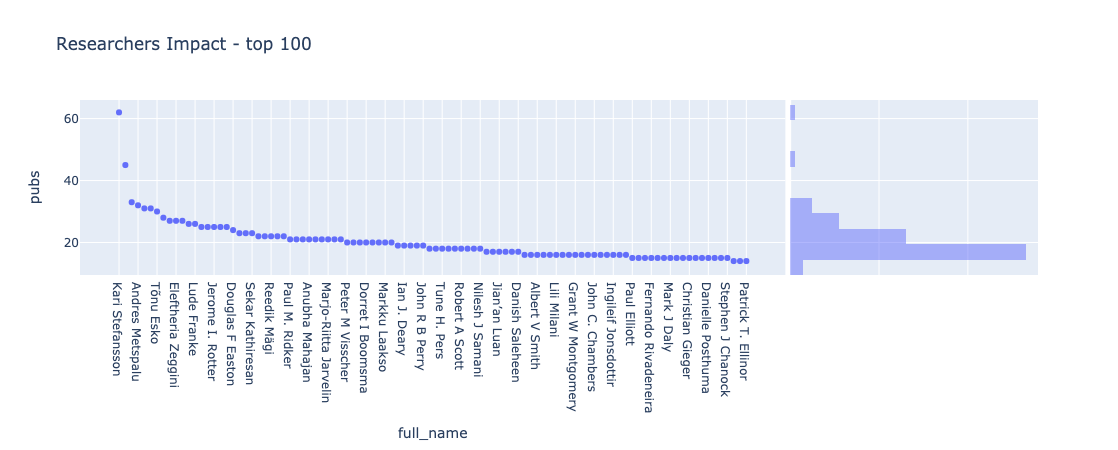

In [14]:
top100 = researchers_impact[:100]
px.scatter(top100, 
           x="full_name", y="pubs", 
           hover_name="full_name", 
           hover_data=['citations_mean', 'altmetric_mean'], 
           marginal_y="histogram", 
           title="Researchers Impact - top 100")

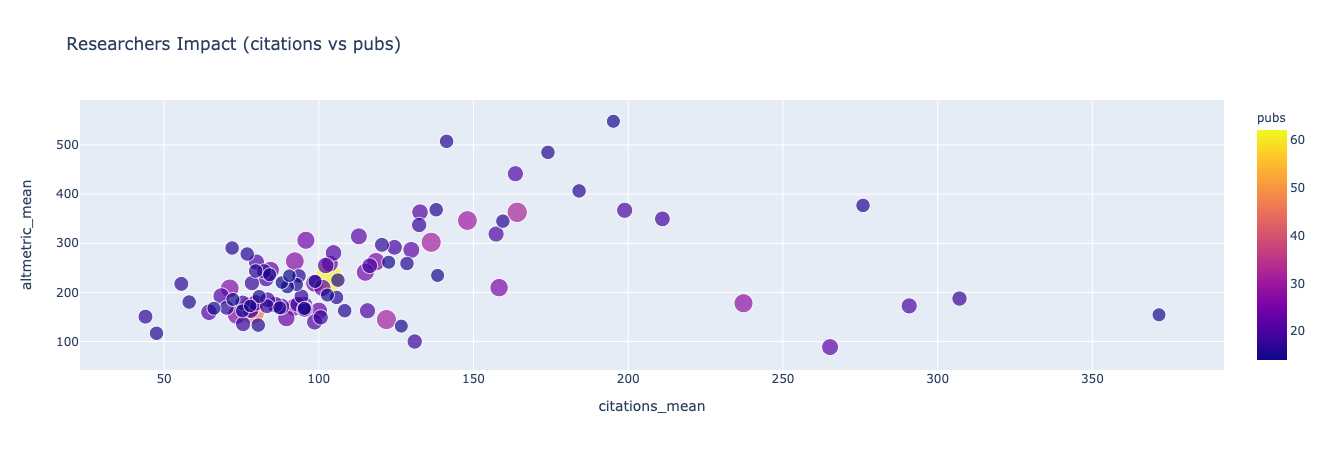

In [19]:
px.scatter(top100, 
           x="citations_mean", y="altmetric_mean", 
           hover_name="full_name", 
           hover_data=['pubs', 'citations_mean', 'altmetric_mean'], 
           color="pubs",
           size="pubs",
           title="Researchers Impact (citations vs pubs)")

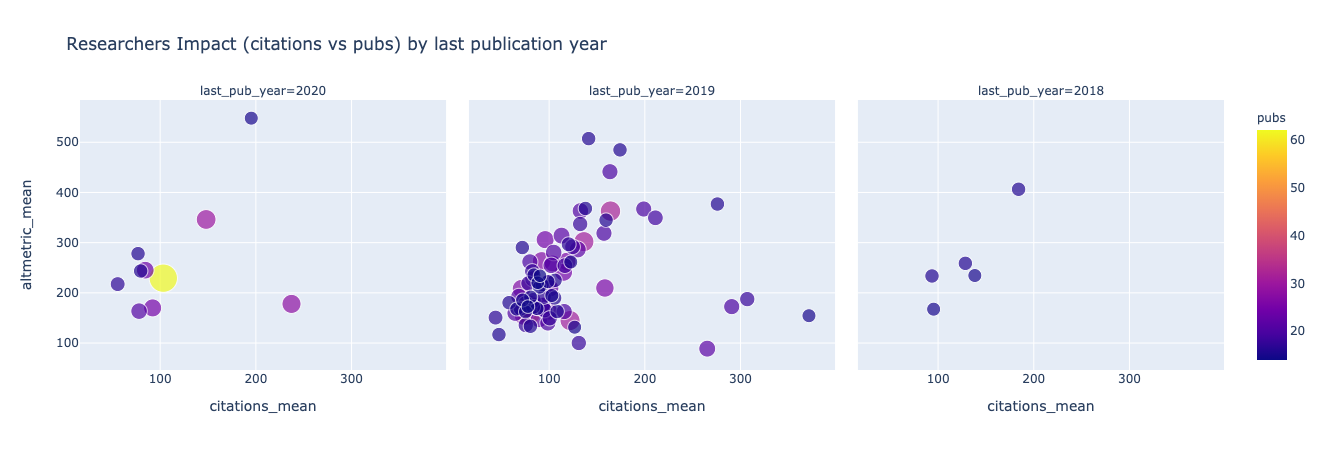

In [22]:
px.scatter(top100, 
           x="citations_mean", y="altmetric_mean", 
           hover_name="full_name", 
           hover_data=['pubs', 'citations_mean', 'altmetric_mean'], 
           color="pubs",
           size="pubs",
           facet_col="last_pub_year",
           title="Researchers Impact (citations vs pubs) by last publication year")